# Adapted from [arXiv:2208.07621](https://arxiv.org/abs/2208.07621)

1D Heisenberg Chain:
$$
H = \sum_{i,j} J(X_iX_j + Y_iY_j + Z_iZ_j) + \sum_i (J_x X_i + J_z Z_i)
$$

Import the necessary tools:

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from itertools import product
import tqdm, scipy

Implement the Hamiltonian:

In [2]:
def heisenberg_chain_1D(nqubits: int, j: float, jx: float, jz: float) -> qml.Hamiltonian:
    """
    1D Heisenberg Chain with transverse fields

    .. math::

        H = \sum_{i,j} J[X_iX_j + Y_iY_j + Z_iZ_j] + \sum_i [J_x X_i + J_z Z_i]

    :param nqubit: number of qubits
    :param jx: J_x parameter
    :param jz: J_z parameter
    """
    first_term = []
    first_term_coefs = []
    for nq in range(nqubits - 1):
        first_term.append(qml.PauliX(nq) @ qml.PauliX(nq + 1))
        first_term_coefs.append(j)
        first_term.append(qml.PauliY(nq) @ qml.PauliY(nq + 1))
        first_term_coefs.append(j)
        first_term.append(qml.PauliZ(nq) @ qml.PauliZ(nq + 1))
        first_term_coefs.append(j)

    second_term = []
    second_term_coefs = []
    for nq in range(nqubits):
        second_term.append(qml.PauliX(nq))
        second_term_coefs.append(jx)
        second_term.append(qml.PauliZ(nq))
        second_term_coefs.append(jz)

    return qml.Hamiltonian(first_term_coefs + second_term_coefs, first_term + second_term)

Fix initial constants:

In [3]:
NQUBITS = 4
J = -1
JX = 0.3
JZ = 0.2
BETA = 1.3
NLAYERS = 3

Lets check the Hamiltonian:

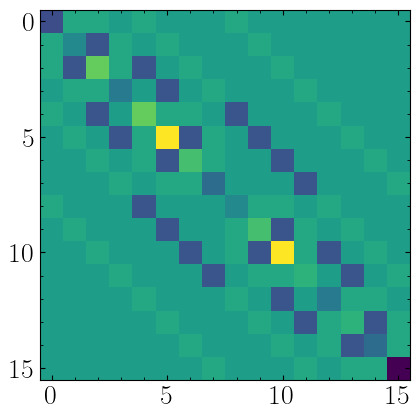

/Users/jackaraz/packages/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


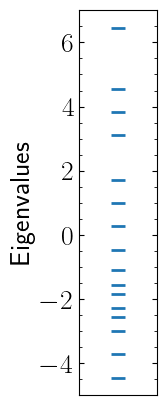

In [4]:
H = qml.matrix(heisenberg_chain_1D(NQUBITS, J, JX, JZ))
plt.imshow(H.real)
plt.show()
e = np.linalg.eig(H)[0]

fig = plt.figure(figsize=(1, 5))
plt.scatter([0.0] * len(e), e, marker="_", s=100)
plt.ylabel("Eigenvalues")
plt.xlim([-0.1, 0.1])
plt.xticks([])
plt.show()

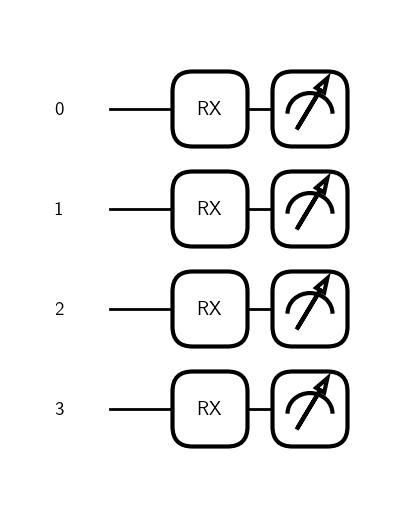

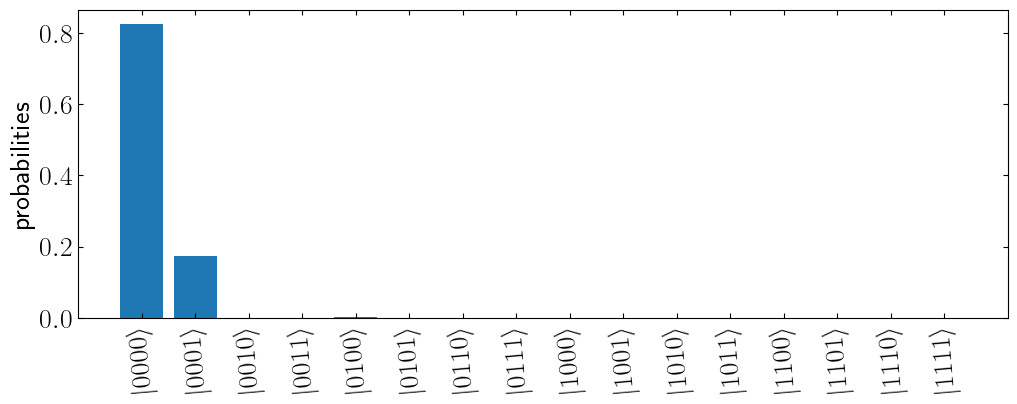

In [5]:
vqc1_dev = qml.device("default.qubit", wires=range(4))


@qml.qnode(vqc1_dev)
def VQC1(params: np.ndarray) -> np.ndarray:
    for nq in range(NQUBITS):
        # from 2208.07621 p4 sec III.1 (minimal entropy circuit)
        qml.RX(params[nq], wires=nq)
    return qml.probs(wires=range(NQUBITS))


qml.draw_mpl(VQC1)(np.random.uniform(-1, 1, (NQUBITS,)))
plt.show()

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)

states = list(product([0, 1], repeat=NQUBITS))

probs = VQC1(np.random.uniform(-1, 1, (NQUBITS,)))

ax.bar(range(len(states)), probs, width=0.8)
ax.set_xticks(
    range(len(states)),
    labels=["$|" + "".join(str(x)[1:-1].split(",")) + "\\rangle$" for x in states],
    minor=False,
    rotation=95,
    fontsize=20,
)
ax.set_ylabel("probabilities")
ax.minorticks_off()
plt.show()

In [6]:
shapes = qml.SimplifiedTwoDesign.shape(NLAYERS, NQUBITS)

vqc2_dev = qml.device("default.qubit", wires=range(NQUBITS))


def VQC2(initial_state: list[int], initial_params: np.ndarray, weights: np.ndarray) -> None:
    qml.BasisStatePreparation(initial_state, wires=range(NQUBITS))
    qml.SimplifiedTwoDesign(
        initial_layer_weights=initial_params, weights=weights, wires=range(NQUBITS)
    )


@qml.qnode(vqc2_dev)
def circuit(
    initial_state: list[int], initial_params: np.ndarray, weights: np.ndarray, hamil
) -> np.ndarray:
    VQC2(initial_state, initial_params, weights)
    return qml.expval(hamil)


vqc2_dev_state = qml.device("default.qubit", wires=range(NQUBITS))


@qml.qnode(vqc2_dev_state)
def circuit_state(
    initial_state: list[int], initial_params: np.ndarray, weights: np.ndarray
) -> np.ndarray:
    VQC2(initial_state, initial_params, weights)
    return qml.state()

$$
\rho = \sum_i p_i |s_i\rangle\langle s_i | \\
\langle \rho H \rangle = {\rm Tr}\left[\rho U(\phi) H U^\dagger(\phi)\right]\\
{\rm Tr}\left[\rho U(\phi) H U^\dagger(\phi)\right] = \sum_i p_i  {\rm Tr}\left[|s_i\rangle\langle s_i| U(\phi) H U^\dagger(\phi)\right]
$$

In [8]:
def cost(phi1: np.ndarray, phi2: np.ndarray, phi3: np.ndarray, hamil) -> np.ndarray:
    probs = VQC1(phi1)

    # QC is a pure state simulator, we need to compute the energy
    # of the mixed state i.e. rho = Sum p_i |s_i><s_i|
    # Tr[rho U(phi) H U^dag(phi)] = Sum p_i * Tr[|s_i><s_i| U(phi) H U^dag(phi)]
    energy, entropy = 0.0, 0.0
    for idx, state in enumerate(product([0, 1], repeat=NQUBITS)):
        if probs[idx] != 0.0:
            entropy -= probs[idx] * np.log(probs[idx])
            energy += probs[idx] * circuit(state, phi2, phi3, hamil)

    return energy - entropy / BETA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s, Epoch 99/100 : free energy = -4.62318e+00, ETA = 0.0125]


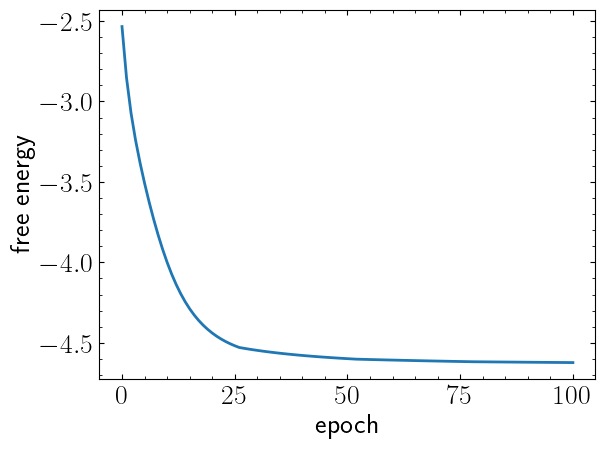

In [9]:
phi1 = np.random.uniform(-np.pi, np.pi, (NQUBITS,))
phi2 = np.random.uniform(-np.pi, np.pi, shapes[0])
phi3 = np.random.uniform(-np.pi, np.pi, shapes[1])

Hamiltonian = heisenberg_chain_1D(NQUBITS, J, JX, JZ)
cost_fn = lambda phi1, phi2, phi3: cost(phi1, phi2, phi3, Hamiltonian)

gfun = qml.grad(cost_fn, argnum=[0, 1, 2])
ETA = 1e-1
EPOCHS = 100


free_energy = [cost_fn(phi1, phi2, phi3)]
decay_counter = 0
with tqdm.tqdm(total=EPOCHS) as pbar:
    for epoch in range(EPOCHS):
        grads = gfun(phi1, phi2, phi3)
        phi1 -= ETA * grads[0]
        phi2 -= ETA * grads[1]
        phi3 -= ETA * grads[2]

        free_energy.append(cost_fn(phi1, phi2, phi3))
        pbar.update()
        pbar.set_postfix_str(
            f"Epoch {epoch}/{EPOCHS} : free energy = {free_energy[-1]:.5e}, ETA = {ETA}"
        )

        decay_counter += 1
        if len(free_energy) > 25 and decay_counter > 25:
            if np.abs(np.min(free_energy[20:]) - free_energy[-1]) < 1e-4:
                decay_counter = 0
                ETA *= 0.5

plt.plot(range(EPOCHS+1), free_energy)
plt.ylabel("free energy")
plt.xlabel("epoch")
plt.show()

Construct the mixed state:

In [11]:
probs = VQC1(phi1)

state = np.zeros(shape=(16, 16)).astype(np.complex128)
for idx, st in enumerate(product([0, 1], repeat=NQUBITS)):
    if probs[idx] != 0.0:
        current_state = circuit_state(st, phi2, phi3).reshape(-1, 1)
        state += probs[idx] * current_state @ current_state.T.conj()

Compare truth and the reconstruction:

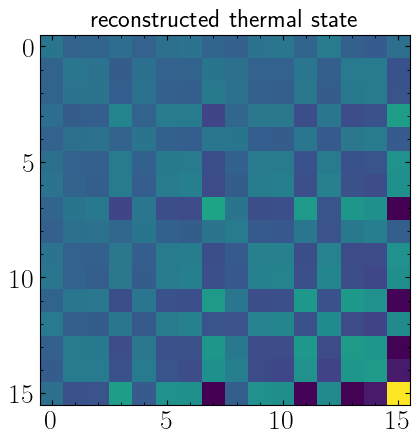

Actual free energy : -4.88, energy = -3.86, entropy = 1.33


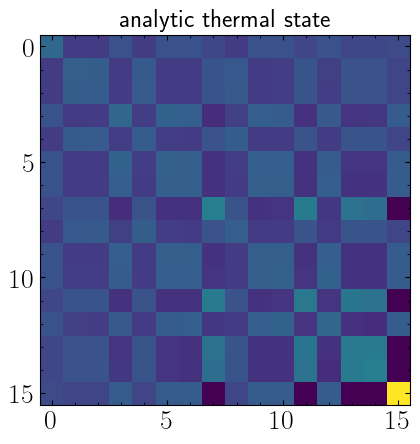

In [12]:
plt.imshow(state.real)
plt.title("reconstructed thermal state", fontsize=18)
plt.show()

H = qml.matrix(Hamiltonian)
exp = scipy.linalg.expm(-BETA * H)
rho_thermal = exp / np.trace(exp)

entropy = -np.trace(rho_thermal @ scipy.linalg.logm(rho_thermal))
energy = np.trace(np.matmul(rho_thermal, H))
free_energy = energy - entropy / BETA
print(
    f"Actual free energy : {free_energy.real:.2f}, energy = {energy.real:.2f}, entropy = {entropy.real:.2f}"
)

plt.imshow(rho_thermal.real)
plt.title("analytic thermal state", fontsize=18)
plt.show()

/Users/jackaraz/packages/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


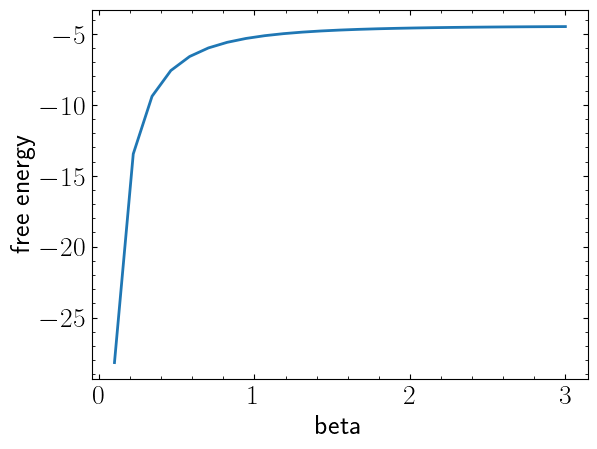

In [13]:
H = qml.matrix(Hamiltonian)
beta = np.linspace(0.1,3,25)
fe = []
for b in beta:

    exp = scipy.linalg.expm(-b * H)
    rho_thermal = exp / np.trace(exp)

    entropy = -np.trace(rho_thermal @ scipy.linalg.logm(rho_thermal))
    energy = np.trace(np.matmul(rho_thermal, H))
    free_energy = energy - entropy / b
    fe.append(free_energy)

plt.plot(beta, fe)
plt.xlabel("beta")
plt.ylabel("free energy")
plt.show()